Author: Misha Barth
# Tutorial: Kinda-fast weighted binned statistics (ooh, fancy!)

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import tqdm

## Imagine our true visibility space (before sampling) looks like this:

In [3]:
data_x, data_y = np.meshgrid(np.linspace(0, 99, 100), np.linspace(0, 99, 100))

In [4]:
data = data_x+data_y

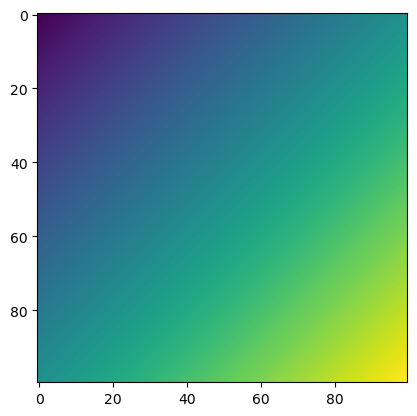

In [5]:
plt.imshow(data)

In [6]:
data.shape

(100, 100)

## Now let's sample the u-v plane, let's say we only have the positions along the diagonal

In [7]:
u_coords = np.linspace(0, 99, 100)
v_coords = np.linspace(0, 99, 100)
vis = np.linspace(0, 198, 100)

## Let's bin this into 10 bins along the diagonal

In [8]:
binned, _, _, _ = stats.binned_statistic_2d(x = u_coords, y = v_coords, values = vis, bins = (10, 10), statistic = "mean")

In [9]:
binned.shape

(10, 10)

In [10]:
binned

array([[  9.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  29.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  49.,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  69.,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  89.,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan, 109.,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan, 129.,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan, 149.,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, 169.,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, 189.]])

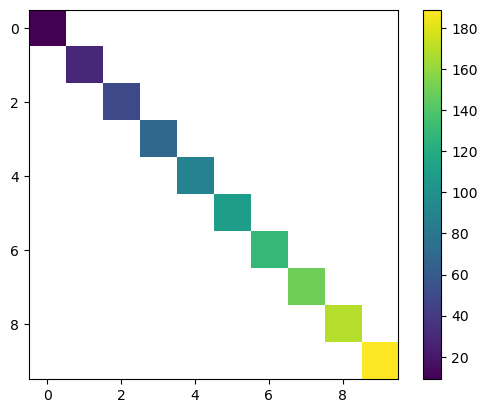

In [11]:
plt.imshow(binned)
plt.colorbar()
plt.show()

## Nice! Now let's do a weighted mean, where the weights within each bin will increase from 0 at the low end of the bin to 10 at the high end of the bin. Thus, each bin will have a larger value than before.

In [12]:
values = np.linspace(0, 198, 100)
weights = np.tile(np.linspace(0, 10, 10), 10)

## We will first do things the simple way...

In [13]:
binned_weighted_simple_sum, _, _, _ = stats.binned_statistic_2d(x = u_coords, y = v_coords, values = values*weights, bins = (10, 10), statistic = "sum")
binned_weighted_simple_sum_weights, _, _, _ = stats.binned_statistic_2d(x = u_coords, y = v_coords, values = weights, bins = (10, 10), statistic = "sum")
binned_weighted_simple = binned_weighted_simple_sum / binned_weighted_simple_sum_weights

C:\Users\noedi\AppData\Local\Temp\ipykernel_10696\2004378232.py:3: RuntimeWarning: invalid value encountered in divide
  binned_weighted_simple = binned_weighted_simple_sum / binned_weighted_simple_sum_weights


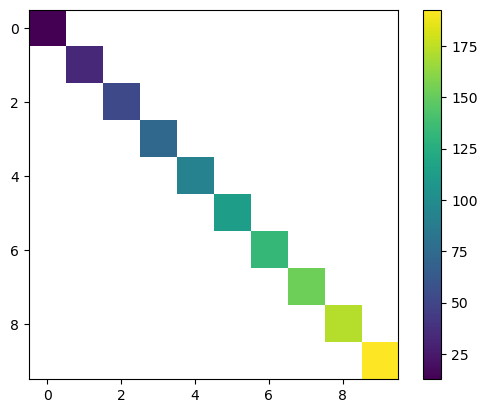

In [14]:
plt.imshow(binned_weighted_simple)
plt.colorbar()
plt.show()

In [15]:
binned_weighted_simple

array([[ 12.66666667,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,  32.66666667,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,          nan,  52.66666667,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,          nan,          nan,  72.66666667,
                 nan,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,          nan,          nan,          nan,
         92.66666667,          nan,          nan,          nan,
                 nan,          nan],
       [         nan,          nan,          nan,          nan,
                 nan, 112.66666667,          nan,          nan,
                 nan,          nan],
       [  

## Is this correct? Let's manually check the first bin value

In [16]:
np.average(np.linspace(0, 198, 100)[0:10], weights = np.linspace(0, 10, 10))

12.666666666666664

### Yup, all good! But it is no good if you want to do a weighted standard deviation, since the numerator is a weighted sum of squared differences, where the mean inside the squared differences is a weighted mean. So you can't just multiply the values by their sqrt(weights), use std, and divide by the sum of the weights, because you'd be subtracting the wrong type of mean inside each squared difference. Thankfully, binned_statistic allows you to define a custom function, although you can't give it any other args, and it complains if it accidentally transforms your data into the wrong shape. SO we have to get creative. Let's start with doing the mean:

In [17]:
def binned_mean(y):
    y = np.stack(y)
    values = y[:, 0]
    w = y[:, 1]
    return np.average(values, weights = w)

## Data transformation to satisfy the gremlins inside binned_statistic:

In [18]:
y = list(zip(values, weights))
data = np.empty(100, dtype = object)
data[:] = y

In [19]:
binned_weighted, _, _, _ = stats.binned_statistic_2d(x = np.linspace(0, 99, 100), y = np.linspace(0, 99, 100), values = data, bins = (10, 10), statistic = binned_mean)

In [20]:
binned_weighted

array([[12.666666666666664, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, 32.66666666666667, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, 52.66666666666667, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, 72.66666666666667, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, 92.66666666666669, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, 112.66666666666666, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, 132.66666666666666, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, 152.66666666666669, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, 172.66666666666663, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, 192.66666666666669]],
      dtype=object)

## Now let's do standard deviation!

Extra note for nerds: Weighted variances in astro (and in life) can get complicated. Luckily, we are in Case II, as described here: http://seismo.berkeley.edu/~kirchner/Toolkits/Toolkit_12.pdf

So we can use the usual formula which numpy uses, yay

In [21]:
def binned_std(y):
    y = np.stack(y)
    values = y[:, 0]
    w = y[:, 1]
    return np.sqrt(np.cov(values, aweights=w)) #have to use cov since std doesn't accept weights :(

In [22]:
binned_weighted_std, _, _, _ = stats.binned_statistic_2d(x = np.linspace(0, 99, 100), y = np.linspace(0, 99, 100), values = data, bins = (10, 10), statistic = binned_std)

In [23]:
binned_weighted_std

array([[4.77059961531621, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, 4.77059961531621, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, 4.77059961531621, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, 4.77059961531621, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, 4.77059961531621, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, 4.77059961531621, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, 4.77059961531621, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, 4.77059961531621, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, 4.77059961531621, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, 4.77059961531621]],
      dtype=object)

## Make sure it's correct:

In [24]:
np.sqrt(np.cov(values[0:10], aweights=weights[0:10]))

4.77059961531621

## And compare to unweighted standard deviation:

In [25]:
np.std(values[0:10])

5.744562646538029

: 

## These two pictures are not the same! Happy coding :)))